#### Librerías

In [ ]:
!pip install --upgrade lightgbm

In [ ]:
!pip install spacy_transformers

In [ ]:
!python -m spacy download en_core_web_trf

In [17]:
!pip install xgboost

In [18]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
#import spacy_transformers
import multiprocessing
from sklearn.pipeline import Pipeline
import xgboost as xgb
from collections import Counter

from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

import ast
from sklearn.preprocessing import MultiLabelBinarizer

from itertools import product
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


In [4]:
#Dataset
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

## Análisis exploratorio

In [ ]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [ ]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [ ]:
#Busca nulos
print(dataTraining.isnull().sum())

year      0
title     0
plot      0
genres    0
rating    0
dtype: int64


In [ ]:
#Comteno inicial de grupos de géneros
dataTraining['genres'].value_counts()

[Drama]                                                   429
[Comedy]                                                  368
[Comedy, Drama, Romance]                                  306
[Comedy, Romance]                                         291
[Comedy, Drama]                                           287
                                                         ... 
[Action, Adventure, Comedy, Fantasy, Thriller]              1
[Action, Adventure, Crime, Drama, Sci-Fi]                   1
[Drama, Action, Crime]                                      1
[Biography, Comedy, Crime, Drama, Romance]                  1
[Animation, Adventure, Drama, Family, Fantasy, Sci-Fi]      1
Name: genres, Length: 1336, dtype: int64

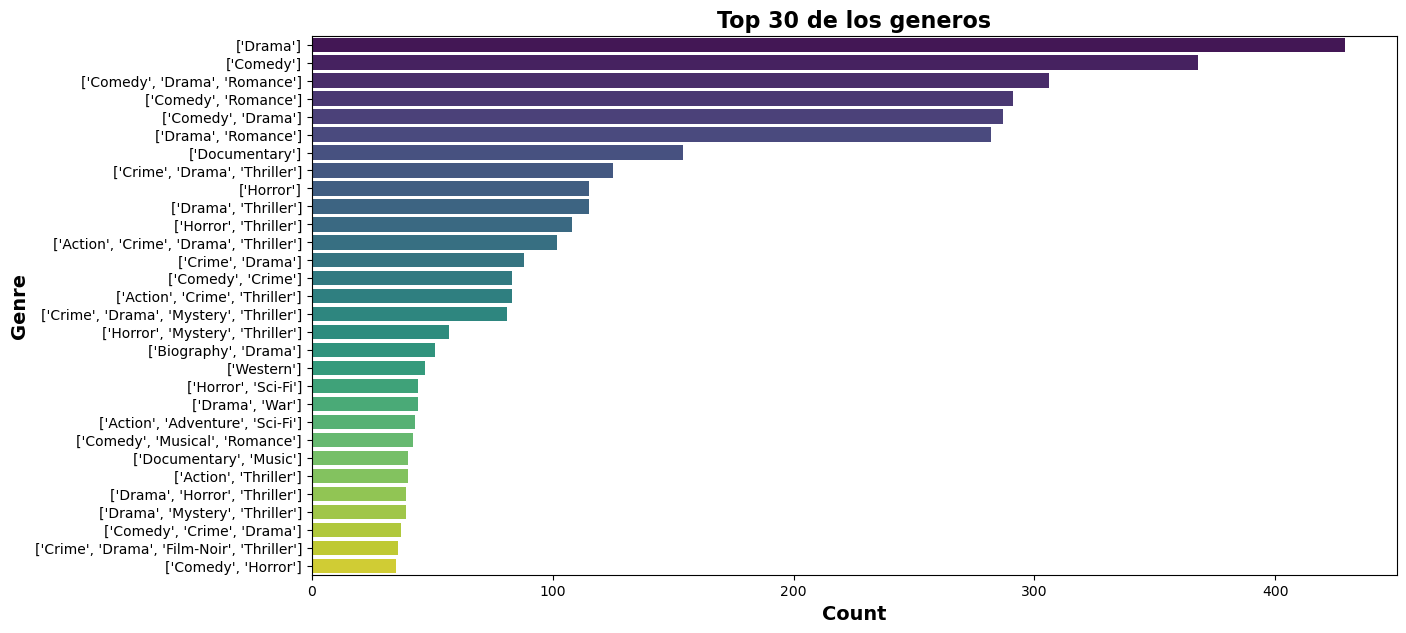

In [ ]:
#top 30 grupos de géneros
top_genres = dataTraining['genres'].value_counts().nlargest(30)

plt.figure(figsize=(14, 7))
sns.barplot(x=top_genres, y=top_genres.index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')
plt.title('Top 30 de los generos', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
print(dataTraining.describe())

              year       rating
count  7895.000000  7895.000000
mean   1989.726409     6.402812
std      22.660717     1.078260
min    1894.000000     1.200000
25%    1980.000000     5.800000
50%    1997.000000     6.500000
75%    2007.000000     7.200000
max    2015.000000     9.300000


In [ ]:
# Obtiene lista de géneros únicos y cantidad (24)
def parse_genre_list(genre_string):
    genres = re.findall(r"'(.*?)'", genre_string)
    return genres

dataTraining['genres'] = dataTraining['genres'].apply(parse_genre_list)
all_genres = [genre for sublist in dataTraining['genres'] for genre in sublist]
unique_genres = set(all_genres)

# Imprimir géneros únicos
for genre in unique_genres:
    print(genre)

print(len(unique_genres))

Crime
Music
Short
Adventure
Animation
Biography
Action
Sport
Documentary
Family
Drama
War
Comedy
Romance
Film-Noir
History
Thriller
Mystery
Horror
Western
Musical
Fantasy
Sci-Fi
News
24


In [ ]:
#Géneros de las películas frecuencias y %
genre_frequency = pd.Series(all_genres).value_counts()

# Crear un DataFrame con los géneros únicos y sus frecuencias
unique_genres_df = pd.DataFrame({
    'Genre': genre_frequency.index,
    'Frequency': genre_frequency.values,
    '%': genre_frequency.values/len(all_genres) * 100
})

In [ ]:
unique_genres_df

,Genre,Frequency,%
0,Drama,3965,18.376900
1,Comedy,3046,14.117538
2,Thriller,2024,9.380793
3,Romance,1892,8.769003
4,Crime,1447,6.706526
5,Action,1303,6.039118
6,Adventure,1024,4.746014
7,Horror,954,4.421580
8,Mystery,759,3.517798
9,Sci-Fi,723,3.350945


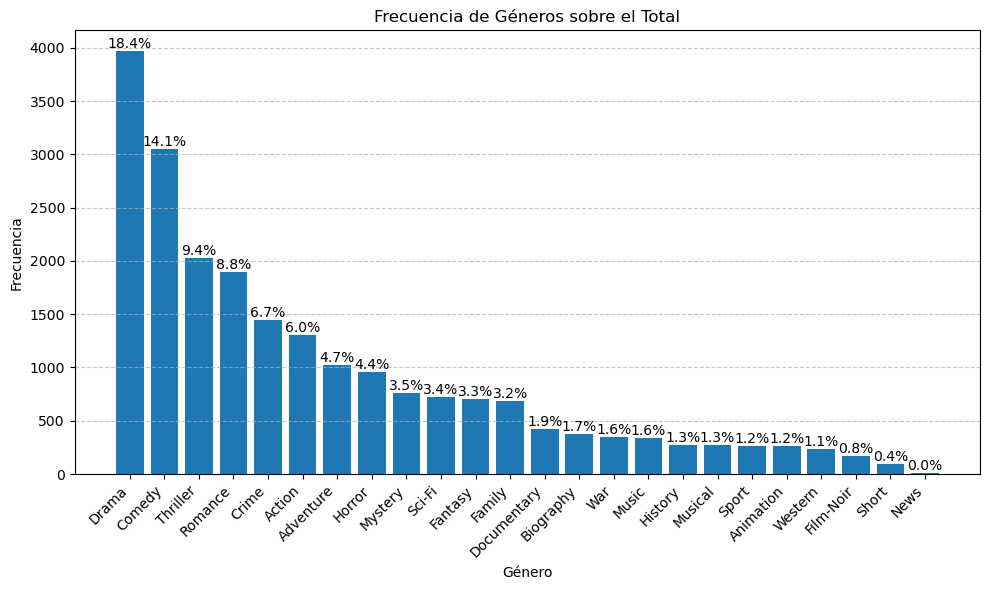

In [ ]:
# Ordenar los géneros por frecuencia de mayor a menor
unique_genres_df = unique_genres_df.sort_values(by='Frequency', ascending=False)

# Crear la gráfica
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(unique_genres_df)), unique_genres_df['Frequency'])

# Agregar las frecuencias encima de las barras con un solo decimal
for bar, frequency in zip(bars, unique_genres_df['%']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{frequency:.1f}%', ha='center', va='bottom')

# Añadir títulos y etiquetas
plt.title('Frecuencia de Géneros sobre el Total')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.xticks(range(len(unique_genres_df)), unique_genres_df['Genre'], rotation=45, ha='right')  # Establecer etiquetas del eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar la gráfica
plt.show()



In [ ]:
#Años de publicación de las películas frecuencias y %
years = dataTraining['year'].value_counts().sort_index(ascending=False)
years_unicos = pd.DataFrame({
    'Year': years.index,
    'Frecuencia': years.values,
    '%': (years.values/len(dataTraining))*100
})

years_unicos

,Year,Frecuencia,%
0,2015,49,0.620646
1,2014,242,3.065231
2,2013,288,3.647878
3,2012,277,3.508550
4,2011,266,3.369221
...,...,...,...
101,1914,1,0.012666
102,1910,1,0.012666
103,1903,1,0.012666
104,1896,1,0.012666


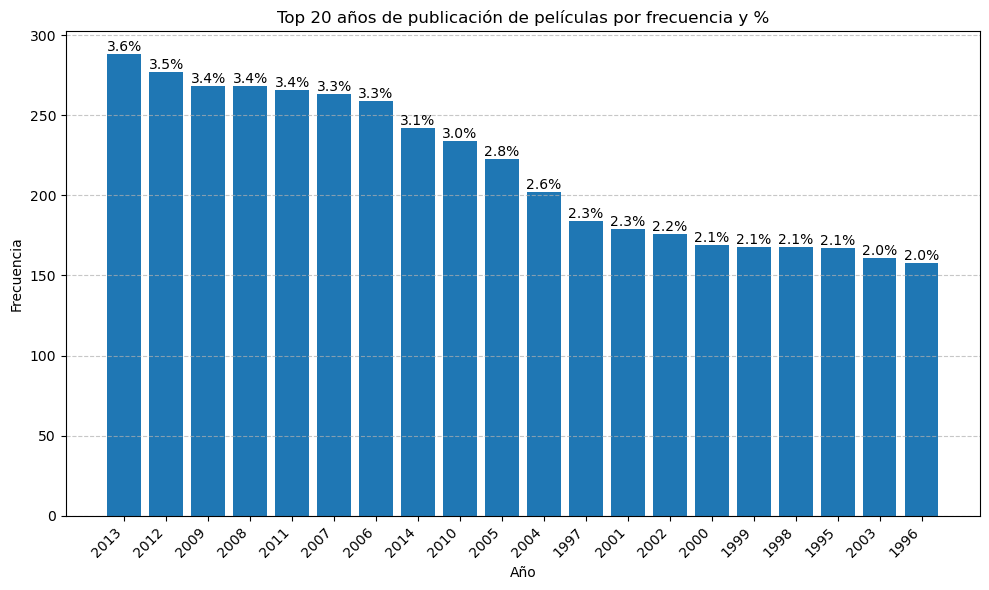

In [ ]:
#Gráfico para los años (top 20)
top_20 = (years_unicos.sort_values(by='Frecuencia', ascending=False)).head(20)

# Crear la gráfica
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(top_20)), top_20['Frecuencia'])

# Agregar los porcentajes encima de las barras
for bar, percentage in zip(bars, top_20['%']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

plt.title('Top 20 años de publicación de películas por frecuencia y %')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(range(len(top_20)), top_20['Year'], rotation=45, ha='right')  # Establecer etiquetas del eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
max_rating = dataTraining['rating'].max()
min_rating = dataTraining['rating'].min()
mean_rating = dataTraining['rating'].mean()

print("Mayor rating:", max_rating)
print("Menor rating:", min_rating)
print("Media del rating:", mean_rating)

Mayor rating: 9.3
Menor rating: 1.2
Media del rating: 6.4028119062697995


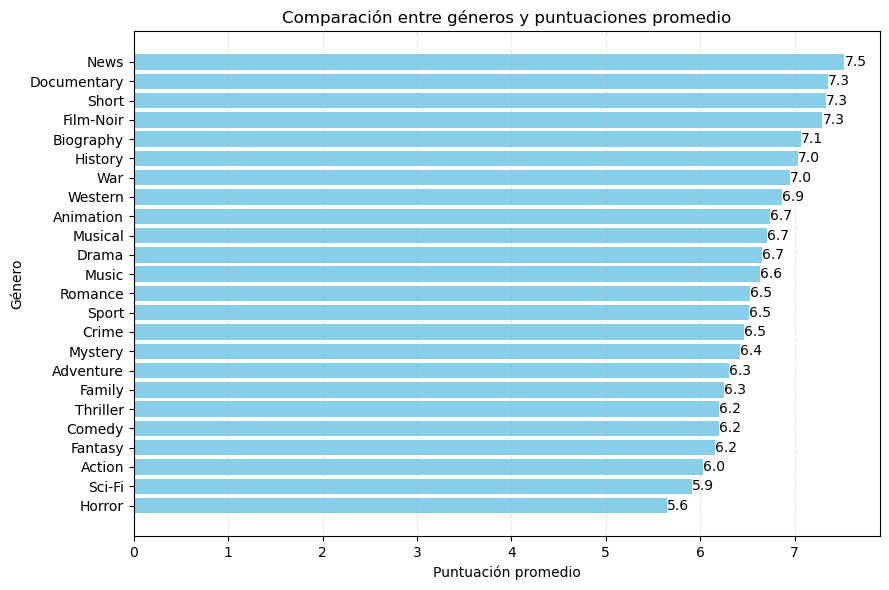

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Expandir las listas de géneros en filas individuales
expanded_df = dataTraining.explode('genres')

# Calcular la puntuación promedio para cada género
average_ratings = expanded_df.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Ordenar los géneros por puntuación promedio de mayor a menor
average_ratings_sorted = average_ratings.sort_values(ascending=True)

# Crear el gráfico de barras horizontal
plt.figure(figsize=(9, 6))
bars = plt.barh(range(len(average_ratings_sorted)), average_ratings_sorted.values, color='skyblue')

# Agregar los porcentajes sobre las barras
for i, bar in enumerate(bars):
    percentage = average_ratings_sorted.values[i]
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{percentage:.1f}', ha='left', va='center')

# Añadir títulos y etiquetas
plt.title('Comparación entre géneros y puntuaciones promedio')
plt.xlabel('Puntuación promedio')
plt.ylabel('Género')
plt.yticks(range(len(average_ratings_sorted)), average_ratings_sorted.index)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

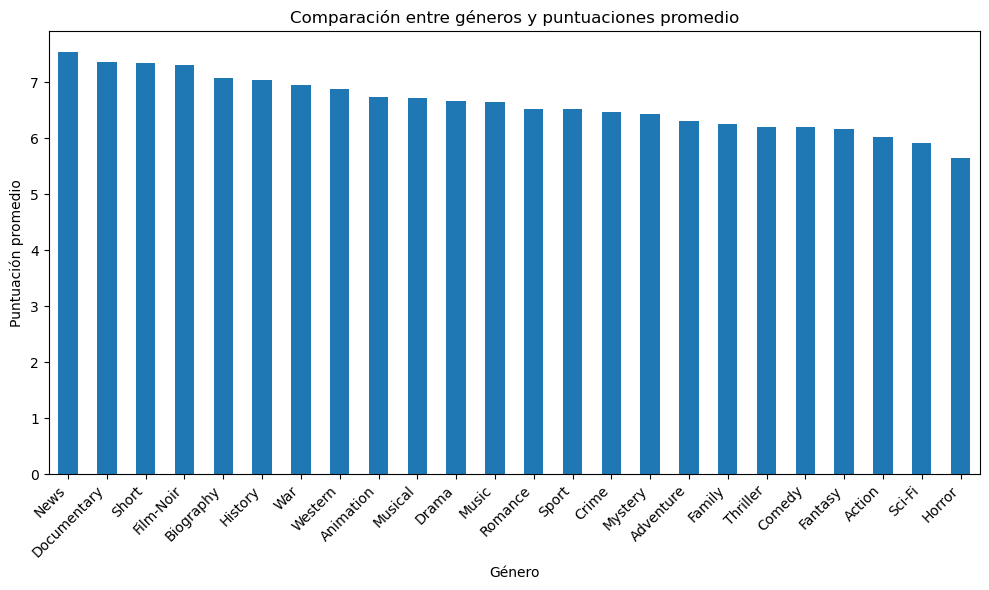

In [ ]:
# Expandir las listas de géneros en filas individuales
expanded_df = dataTraining.explode('genres')

# Calcular la puntuación promedio para cada género
average_ratings = expanded_df.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
average_ratings.plot(kind='bar')
plt.title('Comparación entre géneros y puntuaciones promedio')
plt.xlabel('Género')
plt.ylabel('Puntuación promedio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
#Palabra más usadas
# Combina todos los textos en una sola cadena
text_combined = ' '.join(dataTraining['plot'])

# Tokeniza el texto en palabras y convierte a minúsculas
words = [word.lower() for word in nltk.word_tokenize(text_combined)]

# Elimina las palabras vacías (stop words) en inglés
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Cuenta la frecuencia de cada palabra
word_counts = Counter(filtered_words)

# Muestra las 50 palabras más comunes
for word, count in word_counts.most_common(50):
    print(f'{word}: {count}')

,: 57327
.: 46614
': 15571
-: 10466
``: 4776
n: 3832
one: 3010
life: 2721
new: 2255
(: 2072
): 2059
man: 1927
two: 1728
get: 1713
family: 1599
love: 1530
find: 1457
father: 1454
time: 1433
young: 1356
also: 1311
old: 1249
finds: 1243
world: 1211
back: 1210
;: 1202
years: 1201
friend: 1189
wife: 1173
?: 1136
:: 1112
home: 1057
wants: 1044
way: 1040
mother: 1033
help: 1024
friends: 1001
go: 989
school: 986
however: 985
make: 961
house: 948
day: 940
first: 929
woman: 924
lives: 916
story: 911
son: 903
town: 900
soon: 892


## Procesamieto del texto

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
unique_genres = set()

# Iterar por cada fila para extraer los diferentes géneros.
for genres_string in dataTraining['genres'][:3]:
    genres_list = eval(genres_string)  # Evalúa la expresión para convertir la cadena a una lista de géneros
    unique_genres.update(genres_list)

unique_genres = set(genre for genres_string in dataTraining['genres'][:3] for genre in eval(genres_string))

print(sorted(unique_genres))

['Comedy', 'Crime', 'Drama', 'Film-Noir', 'Horror', 'Short', 'Thriller']


In [9]:
dataTraining['genres'] = dataTraining['genres'].map(ast.literal_eval)

matriz = MultiLabelBinarizer()

# Vectoriza los géneros del conjunto de entrenamiento
y = matriz.fit_transform(dataTraining['genres'])

#Lematizador
lematizador = WordNetLemmatizer()
#Stemming
stemming = PorterStemmer()
stemmingsnow = SnowballStemmer('english')

#Modelo en ingles de spacy
nlp = spacy.load("en_core_web_sm")

#Añadir stopwords adicionales que se consideren necesarios
stopwords_adicionales = ["is", "the","huw","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
stopwords_en.extend(stopwords_adicionales)

In [10]:
def eliminar_nombres(text):
    doc = nlp(text)

    # Filtrar palabras que son nombres propios, personas, numeros ordinales y cardinales
    filtro = [token.text for token in doc if not token.ent_type_ in ('PERSON')]

    text = ' '.join(filtro)

    return text

In [11]:
def preprocesamiento(text):
    # Convertir todo a lowercase
    text = text.str.lower()

    # Eliminar stopwords
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_en]))

    # Quitar caracteres que no sean letras (Se eliminan caracteres especiales y números)
    text = text.apply(lambda x: ' '.join([re.sub(r'[^a-zA-Z]', '', word) for word in x.split()]))

    # Quitar espacios en blanco
    text = text.apply(lambda x: ' '.join(x.split()))

    # Lematización
    text = text.apply(lambda x: ' '.join([lematizador.lemmatize(word) for word in x.split()]))

    # Stemming (usando Porter Stemmer)
    text = text.apply(lambda x: ' '.join([stemming.stem(word) for word in x.split()]))

    return text

dataTraining['plot'] = preprocesamiento(dataTraining['plot'])

## Modelos

###XG Boost

In [12]:
#Vector
vectxg = CountVectorizer(min_df=3,binary = True)
X = vectxg.fit_transform(dataTraining['plot'])
X.shape

(7895, 11019)

In [13]:
#Partición Train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1306)

In [14]:
insumo_modelos=['Modelo','Arboles','Profundidad','Learning_Rate','AUC_Train','AUC_Test']
results=pd.DataFrame(columns=insumo_modelos)

In [15]:
# Parámetros/Factores Fijos
min_fx = 1
reg_lambda_fx = 5
subsample_fx = 0.8

# Parámetros/Factores Variables
n_estimators = [150] #Numero de estimadores
max_depth = [11]
learning_rate = [0.1]

# Configuración de hiperparámetros
hyperparameters = {
    'min': min_fx,
    'reg_lambda': reg_lambda_fx,
    'subsample': subsample_fx,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate
}

# Imprimir los hiperparámetros para referencia
print("Hiperparámetros:")
for key, value in hyperparameters.items():
    print(f'{key}: {value}')

Hiperparámetros:
min: 1
reg_lambda: 5
subsample: 0.8
n_estimators: [150]
max_depth: [11]
learning_rate: [0.1]


In [20]:
np.random.seed(1306)

results_list = []

# Iterar sobre todas las combinaciones de hiperparámetros
for es, dp, lr in product(n_estimators, max_depth, learning_rate):
    # Modelo
    model_exp = xgb.XGBClassifier(
        booster='gbtree', max_depth=dp, learning_rate=lr,
        n_estimators=es, min=min_fx,
        subsample=subsample_fx, reg_lambda=reg_lambda_fx
    )

    # Entrenamiento
    model_exp.fit(X_train, y_train)

    # Predicción sobre Train
    y_train_pred = model_exp.predict_proba(X_train)
    # Predicción sobre Test
    y_test_pred = model_exp.predict_proba(X_test)

    # AUC Train
    AUC_train= roc_auc_score(y_train, y_train_pred, average='macro')
    # AUC Test
    AUC_test= roc_auc_score(y_test, y_test_pred, average='macro')

    # Almacenar en la lista de resultados
    results_list.append(['XGBoost', es, dp, lr, AUC_train, AUC_test])

# Convertir la lista de resultados a DataFrame
results = pd.DataFrame(results_list, columns=insumo_modelos)

# Imprimir resultados finales si es necesario
print(results)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:46:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min" } are not used.

  warnings.warn(smsg, UserWarning)


    Modelo  Arboles  Profundidad  Learning_Rate  AUC_Train  AUC_Test
0  XGBoost      150           11            0.1   0.990584  0.860095


### Regresión logística

In [21]:
vectrl = TfidfVectorizer(binary = True)
X_dtmrl= vectrl.fit_transform(dataTraining['plot']) #Vector
X_dtmrl.shape

(7895, 26893)

In [22]:
X_train_rl, X_test_rl, y_train_rl, y_test_rl = train_test_split(X_dtmrl, y, test_size=0.25, random_state=1306)

In [23]:
modelo_reglog = LogisticRegression(n_jobs=-1, C=0.01, multi_class='multinomial', solver='lbfgs')

clf_lr_tfidf_preproc = OneVsRestClassifier(modelo_reglog)
clf_lr_tfidf_preproc.fit(X_train_rl, y_train_rl)

OneVsRestClassifier(estimator=LogisticRegression(C=0.01,
                                                 multi_class='multinomial',
                                                 n_jobs=-1))

In [24]:
y_pred_test_rl = clf_lr_tfidf_preproc.predict_proba(X_test_rl)

In [25]:
AUC_test = roc_auc_score(y_test_rl, y_pred_test_rl, average='macro')
round(AUC_test,2)

0.89

In [26]:
y_pred_train_rl = clf_lr_tfidf_preproc.predict_proba(X_train_rl)

In [27]:
AUC_train = roc_auc_score(y_train_rl, y_pred_train_rl, average='macro')
round(AUC_train,2)

0.96

### Random Forest

In [35]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_dtmrl, y, test_size=0.25, random_state=1306)

In [33]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [36]:
clf.fit(X_train_rf, y_train_rf)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [38]:
y_pred_genres = clf.predict_proba(X_test_rf)

In [40]:
roc_auc_score(y_test_rf, y_pred_genres, average='macro')

0.8070165508412805

In [42]:


# Definir el modelo base
modelo_rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Definir los parámetros a ajustar
parametros = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [10, 20]
}

# Crear el clasificador OneVsRestClassifier con RandomForestClassifier
clf = OneVsRestClassifier(modelo_rf)

# Inicializar GridSearchCV para la búsqueda de cuadrícula
grid_search = GridSearchCV(clf, parametros, cv=5, scoring='roc_auc')

# Ajustar la búsqueda de cuadrícula a los datos de entrenamiento
grid_search.fit(X_train_rl, y_train_rl)

# Obtener los mejores parámetros y el mejor estimador
mejores_parametros = grid_search.best_params_
mejor_estimador = grid_search.best_estimator_

# Imprimir los mejores parámetros y la precisión de validación cruzada
print("Mejores parámetros:", mejores_parametros)
print("Precisión de validación cruzada:", grid_search.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 399, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 580, in roc_auc_score
    return _average_binary_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_base.py", line 118, in _average_binary_score
    score[c] = binary_metric(y_true_c, y_score_c, sample_weight=score

Mejores parámetros: {'estimator__max_depth': 10, 'estimator__n_estimators': 100}
Precisión de validación cruzada: nan
